In [153]:
#Importing libraries
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F
import cv2
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop


from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [154]:
#Image directories
X = []
Z = []

Image_Size = 150

Daisy_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/daisy'
Dandelion_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/dandelion'
Rose_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/rose'
Sunflower_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/sunflower'
Tulip_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/tulip'

In [155]:
#Label assigner
def Assign_Label(Image,Flower_Type):
    return Flower_Type

In [156]:
def Make_Train_Data(Flower_Type, Dir):
    for Image in tqdm(os.listdir(Dir)):
        Label = Assign_Label(Image, Flower_Type)
        Path = os.path.join(Dir, Image)
        Image = cv2.imread(Path, cv2.IMREAD_COLOR)
        Image = cv2.resize(Image, (Image_Size, Image_Size))
        
        X.append(np.array(Image))
        Z.append(str(Label))

In [157]:
#Gathering image data
Make_Train_Data('Daisy',Daisy_Dir)

100%|██████████| 764/764 [00:01<00:00, 503.26it/s]


In [158]:
Make_Train_Data('Dandelion', Dandelion_Dir)

100%|██████████| 1052/1052 [00:02<00:00, 467.53it/s]


In [159]:
Make_Train_Data('Rose', Rose_Dir)

100%|██████████| 784/784 [00:01<00:00, 490.36it/s]


In [160]:
Make_Train_Data('Sunflower', Sunflower_Dir)

100%|██████████| 733/733 [00:01<00:00, 391.98it/s]


In [161]:
Make_Train_Data('Tulip', Tulip_Dir)

100%|██████████| 984/984 [00:02<00:00, 453.42it/s]


In [162]:
from sklearn.preprocessing import LabelEncoder


LE = LabelEncoder()
Y = LE.fit_transform(Z)
Y = to_categorical(Y,5)
X = np.array(X)
X = X/255

In [163]:
#Splitting the dataset into a training set (80%) and testing set (20%)
X_Train,X_Test,Y_Train,Y_Test=train_test_split(X,Y,test_size=0.20,random_state=43)

In [164]:
import random as rn
np.random.seed(43)
rn.seed(43)
tf.random.set_seed(43)

In [165]:
#Getting the pre-trained model and changing the starting layer
base_model=VGG16(include_top=False, weights="imagenet",input_shape=(Image_Size,Image_Size,3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [166]:
#Adding two dense layers to the end of the code
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [167]:
#Preprocessing of the training set
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=False)  

datagen.fit(X_Train)

In [168]:
#Setting the training parameters
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

In [169]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 14,847,301
Trainable params: 14,847,301
Non-trainable params: 0
_________________________________________________________________


In [170]:
#Freezing the VGG16 model
base_model.trainable=False # setting the Resnet to be untrainable.

In [171]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [172]:
history = model.fit(datagen.flow(X_Train,Y_Train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_Test,Y_Test),
                              verbose = 1, steps_per_epoch=X_Train.shape[0] // batch_size)

Epoch 1/50
26/26 [==============================] - 123s 5s/step - loss: 1.6114 - accuracy: 0.2749 - val_loss: 1.5373 - val_accuracy: 0.3924
Epoch 2/50
26/26 [==============================] - 115s 4s/step - loss: 1.4790 - accuracy: 0.4505 - val_loss: 1.4190 - val_accuracy: 0.4977
Epoch 3/50
26/26 [==============================] - 116s 4s/step - loss: 1.3632 - accuracy: 0.5462 - val_loss: 1.3093 - val_accuracy: 0.5729
Epoch 4/50
26/26 [==============================] - 117s 5s/step - loss: 1.2689 - accuracy: 0.5820 - val_loss: 1.2182 - val_accuracy: 0.6134
Epoch 5/50
26/26 [==============================] - 116s 5s/step - loss: 1.1800 - accuracy: 0.6171 - val_loss: 1.1328 - val_accuracy: 0.6354
Epoch 6/50
26/26 [==============================] - 120s 5s/step - loss: 1.1047 - accuracy: 0.6418 - val_loss: 1.0622 - val_accuracy: 0.6528
Epoch 7/50
26/26 [==============================] - 116s 4s/step - loss: 1.0448 - accuracy: 0.6550 - val_loss: 1.0073 - val_accuracy: 0.6690
Epoch 8/50
26

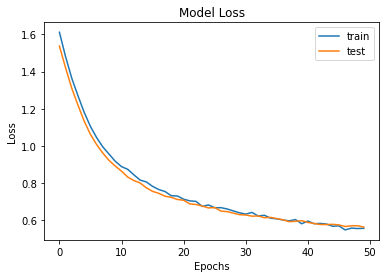

In [173]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

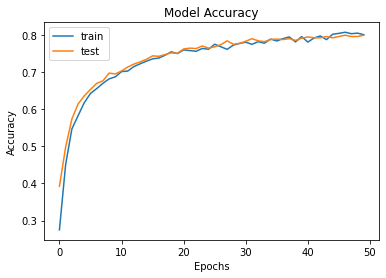

In [174]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [175]:
#Save progress
from tensorflow import keras
model = model
model.save('/Users/joostberkelbach/Documents/Machine Learning/Transfer Learning/Transfer Learning - All layers frozen')

INFO:tensorflow:Assets written to: /Users/joostberkelbach/Documents/Machine Learning/Transfer Learning/Transfer Learning - All layers frozen/assets


In [176]:
#Unfreezing last layer
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
  
for layer in base_model.layers[15:]:
    layer.trainable=True
for layer in base_model.layers[0:15]:
    layer.trainable=False
  

0 <keras.engine.input_layer.InputLayer object at 0x7fdf17a8c550>
1 <keras.layers.convolutional.Conv2D object at 0x7fdf17a8cac0>
2 <keras.layers.convolutional.Conv2D object at 0x7fe053dbc7c0>
3 <keras.layers.pooling.MaxPooling2D object at 0x7fdd03e3bcd0>
4 <keras.layers.convolutional.Conv2D object at 0x7fdcf9778820>
5 <keras.layers.convolutional.Conv2D object at 0x7fdcf78c73a0>
6 <keras.layers.pooling.MaxPooling2D object at 0x7fdcf8357820>
7 <keras.layers.convolutional.Conv2D object at 0x7fe053d2fe50>
8 <keras.layers.convolutional.Conv2D object at 0x7fe053c83340>
9 <keras.layers.convolutional.Conv2D object at 0x7fe053d2fb20>
10 <keras.layers.pooling.MaxPooling2D object at 0x7fe053c83040>
11 <keras.layers.convolutional.Conv2D object at 0x7fdf2d7b6ca0>
12 <keras.layers.convolutional.Conv2D object at 0x7fdcf95ebe20>
13 <keras.layers.convolutional.Conv2D object at 0x7fe053d2fd30>
14 <keras.layers.pooling.MaxPooling2D object at 0x7fdcf95eba30>
15 <keras.layers.convolutional.Conv2D object at 

In [177]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [178]:
history = model.fit(datagen.flow(X_Train,Y_Train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_Test,Y_Test),
                              verbose = 1, steps_per_epoch=X_Train.shape[0] // batch_size)

Epoch 1/50
26/26 [==============================] - 131s 5s/step - loss: 0.5636 - accuracy: 0.7997 - val_loss: 0.5633 - val_accuracy: 0.7975
Epoch 2/50
26/26 [==============================] - 136s 5s/step - loss: 0.5506 - accuracy: 0.8090 - val_loss: 0.5621 - val_accuracy: 0.7998
Epoch 3/50
26/26 [==============================] - 132s 5s/step - loss: 0.5407 - accuracy: 0.8096 - val_loss: 0.5524 - val_accuracy: 0.8021
Epoch 4/50
26/26 [==============================] - 136s 5s/step - loss: 0.5488 - accuracy: 0.8009 - val_loss: 0.5535 - val_accuracy: 0.8009
Epoch 5/50
26/26 [==============================] - 131s 5s/step - loss: 0.5393 - accuracy: 0.8084 - val_loss: 0.5563 - val_accuracy: 0.7998
Epoch 6/50
26/26 [==============================] - 131s 5s/step - loss: 0.5294 - accuracy: 0.8135 - val_loss: 0.5506 - val_accuracy: 0.8044
Epoch 7/50
26/26 [==============================] - 133s 5s/step - loss: 0.5385 - accuracy: 0.8117 - val_loss: 0.5478 - val_accuracy: 0.8056
Epoch 8/50
26

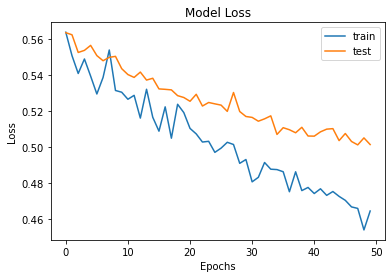

In [179]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

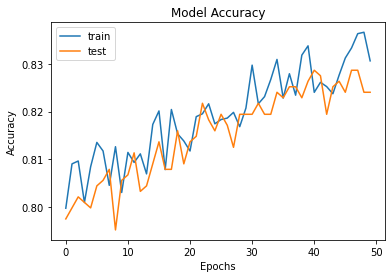

In [180]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [181]:
model = model
model.save('/Users/joostberkelbach/Documents/Machine Learning/Transfer Learning/Transfer Learning - Unfreeze final convolution')

INFO:tensorflow:Assets written to: /Users/joostberkelbach/Documents/Machine Learning/Transfer Learning/Transfer Learning - Unfreeze final convolution/assets


In [182]:
#Unfreezing last two layers
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
  
for layer in base_model.layers[11:]:
    layer.trainable=True
for layer in base_model.layers[0:11]:
    layer.trainable=False
  

0 <keras.engine.input_layer.InputLayer object at 0x7fdf17a8c550>
1 <keras.layers.convolutional.Conv2D object at 0x7fdf17a8cac0>
2 <keras.layers.convolutional.Conv2D object at 0x7fe053dbc7c0>
3 <keras.layers.pooling.MaxPooling2D object at 0x7fdd03e3bcd0>
4 <keras.layers.convolutional.Conv2D object at 0x7fdcf9778820>
5 <keras.layers.convolutional.Conv2D object at 0x7fdcf78c73a0>
6 <keras.layers.pooling.MaxPooling2D object at 0x7fdcf8357820>
7 <keras.layers.convolutional.Conv2D object at 0x7fe053d2fe50>
8 <keras.layers.convolutional.Conv2D object at 0x7fe053c83340>
9 <keras.layers.convolutional.Conv2D object at 0x7fe053d2fb20>
10 <keras.layers.pooling.MaxPooling2D object at 0x7fe053c83040>
11 <keras.layers.convolutional.Conv2D object at 0x7fdf2d7b6ca0>
12 <keras.layers.convolutional.Conv2D object at 0x7fdcf95ebe20>
13 <keras.layers.convolutional.Conv2D object at 0x7fe053d2fd30>
14 <keras.layers.pooling.MaxPooling2D object at 0x7fdcf95eba30>
15 <keras.layers.convolutional.Conv2D object at 

In [183]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [184]:
history = model.fit(datagen.flow(X_Train,Y_Train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_Test,Y_Test),
                              verbose = 1, steps_per_epoch=X_Train.shape[0] // batch_size)

Epoch 1/50
26/26 [==============================] - 125s 5s/step - loss: 0.4670 - accuracy: 0.8316 - val_loss: 0.5045 - val_accuracy: 0.8264
Epoch 2/50
26/26 [==============================] - 126s 5s/step - loss: 0.4590 - accuracy: 0.8338 - val_loss: 0.4961 - val_accuracy: 0.8275
Epoch 3/50
26/26 [==============================] - 127s 5s/step - loss: 0.4632 - accuracy: 0.8316 - val_loss: 0.4983 - val_accuracy: 0.8322
Epoch 4/50
26/26 [==============================] - 126s 5s/step - loss: 0.4568 - accuracy: 0.8358 - val_loss: 0.5028 - val_accuracy: 0.8264
Epoch 5/50
26/26 [==============================] - 123s 5s/step - loss: 0.4542 - accuracy: 0.8385 - val_loss: 0.4961 - val_accuracy: 0.8310
Epoch 6/50
26/26 [==============================] - 124s 5s/step - loss: 0.4640 - accuracy: 0.8319 - val_loss: 0.4959 - val_accuracy: 0.8275
Epoch 7/50
26/26 [==============================] - 127s 5s/step - loss: 0.4560 - accuracy: 0.8364 - val_loss: 0.5011 - val_accuracy: 0.8310
Epoch 8/50
26

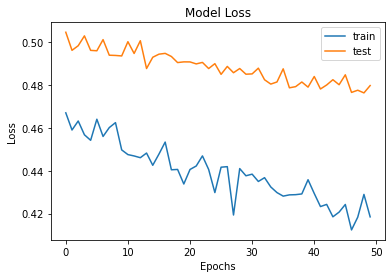

In [185]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

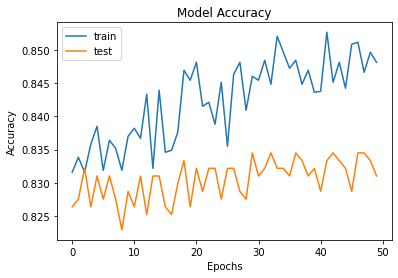

In [186]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [187]:
model = model
model.save('/Users/joostberkelbach/Documents/Machine Learning/Transfer Learning/Transfer Learning - Unfreeze last 2 convolution layers')

INFO:tensorflow:Assets written to: /Users/joostberkelbach/Documents/Machine Learning/Transfer Learning/Transfer Learning - Unfreeze last 2 convolution layers/assets


In [198]:
# getting predictions on val set.
Predictions = model.predict(X_Test)
Predictions_digits=np.argmax(Predictions,axis=1)

In [189]:
#Defining the comfusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Greens")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

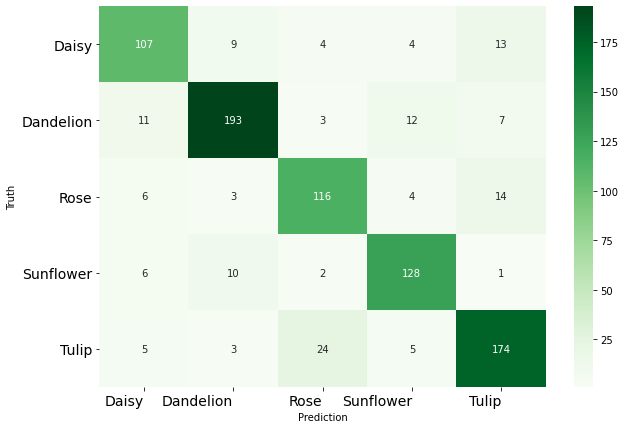

In [190]:
#Making the confusion matrix
obtained = []
truth = []
classes = ['daisy','dandelion','rose','sunflower','tulip']

for i in range(len(Predictions)) : 
    obtained.append(classes[np.argmax(Predictions[i])])
    if Y_Test[i][0]==1:
        truth.append(classes[0])
    elif Y_Test[i][1]==1:
        truth.append(classes[1])
    elif Y_Test[i][2]==1:
        truth.append(classes[2])
    elif Y_Test[i][3]==1:
        truth.append(classes[3])
    elif Y_Test[i][4]==1:
        truth.append(classes[4])

cm = confusion_matrix(truth,obtained)
print_confusion_matrix(cm,['Daisy','Dandelion','Rose','Sunflower','Tulip'])

In [191]:
from sklearn.metrics import f1_score

In [192]:
#F1 score
F1 = f1_score(obtained,truth,average=None)
for i in [0,1,2,3,4]:
    print("F1 score","",classes[i],"     ",F1[i])

F1 score  daisy       0.7867647058823529
F1 score  dandelion       0.8693693693693694
F1 score  rose       0.7945205479452055
F1 score  sunflower       0.8533333333333333
F1 score  tulip       0.8285714285714286


In [193]:
#Assessment metrics
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Recall : " + str(TPR))
#print("Overall Reacll : " + str(np.sum(TPR)))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision: " + str(PPV))
#print("Overall Precision : " + str(np.sum(PPV)))
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Positive likelihood ratio
LR = TPR/FPR

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Accuracy", ACC)
#print("Overall Accuracy: " + str(np.sum(ACC)))

Recall : [0.7810219  0.8539823  0.81118881 0.8707483  0.82464455]
Precision: [0.79259259 0.8853211  0.77852349 0.83660131 0.83253589]
Accuracy [0.93287037 0.93287037 0.93055556 0.94907407 0.91666667]


In [195]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [196]:
get_model_memory_usage(batch_size, model)

0.056